In [17]:
# !pip install optuna
# !pip install shap

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from numpy import percentile
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from tabulate import tabulate
import optuna
import shap
import warnings
warnings.filterwarnings('ignore')

In [11]:
# 1.1 Loading "Breast Cancer Wisconsin" Dataset from scikit-learn
cancer_data = load_breast_cancer()

# 1.2 Creating a Data Frame
X = pd.DataFrame(cancer_data.data, columns=cancer_data.feature_names)
y = pd.Series(cancer_data.target)

# Display the first 5 rows
print(50 * '*')
print(f'\tThe First 5 Rows Of Dataset\n{50 * '*'}\n{X.head()}')

# Target Variable Distribution (0: Malignant, 1: Benign))
print(50 * '*')
print(f'\tTarget Variable (y) Distribution\n{50 * '*'}\n{y.value_counts()}')

**************************************************
	The First 5 Rows Of Dataset
**************************************************
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980  

**Comment:**
The Breast Cancer dataset contains 569 observations and 30 features. Our target variable has binary classes (0 & 1), and the balance between classes is quite good. Feature names are variables with medical significance, such as cell nuclear properties.

In [14]:
# 2. DataSet Quality Controls
# 2.1 Check for missing values ​​in each column

missing_values = X.isnull().sum()
print(f'{50 * '*'}\n\tCheking For Missing Data \n{50 * '*'}')
print(missing_values[missing_values > 0])

**************************************************
	Cheking For Missing Data 
**************************************************
Series([], dtype: int64)


**Comment:**
There are no missing values ​​(NaN) in the dataset. Therefore, no  ($imputation$) is necessary. If there were, a method such as padding with the mean/median could be applied to numeric data.

In [16]:
# 2.2 Outlier Analysis

def detect_outliers_fixed(df, n, features):

    # Use a set to automatically store only unique indices
    outlier_indices = set()

    text = "Outlier Detection Report"
    print(f'{80 *'*'}\n{text.center(80)}\n{80 *'*'}')

    for col in features:

        # Calculate Q1, Q3, and IQR
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1

        # Calculate the lower and upper bounds
        lower_bound = Q1 - (n * IQR)
        upper_bound = Q3 + (n * IQR)

        # Find the row indices where the column value is outside the bounds
        outlier_list_col_indices = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index

        # Add the indices to the set
        outlier_indices.update(outlier_list_col_indices)

        # Using variables for Bolding
        BOLD = '\033[1m'
        END = '\033[0m'

        #  Print the count of outliers per column
        outlier_count = len(outlier_list_col_indices)

        if outlier_count > 0:
            print(f'Feature: {BOLD}{col}{END} -> Detected {BOLD}{outlier_count}{END} outlier(s).')
            # Uncomment the line below for seeing the actual values for debugging
            # print(f'Outlier Values:\n{df.loc[outlier_list_col_indices, col]}')

    print(80*'-')

    # Convert the set back to a sorted list before returning
    return sorted(list(outlier_indices))

# ---  FUNCTION CALL ---
outlier_indices = detect_outliers_fixed(X, 1.5, X.columns)

print(f'Total unique outlier rows detected: {len(outlier_indices)}')
print(f'First 10 outlier indices:{outlier_indices[:10]}')

********************************************************************************
                            Outlier Detection Report                            
********************************************************************************
Feature: mean radius -> Detected 14 outlier(s).
Feature: mean texture -> Detected 7 outlier(s).
Feature: mean perimeter -> Detected 13 outlier(s).
Feature: mean area -> Detected 25 outlier(s).
Feature: mean smoothness -> Detected 6 outlier(s).
Feature: mean compactness -> Detected 16 outlier(s).
Feature: mean concavity -> Detected 18 outlier(s).
Feature: mean concave points -> Detected 10 outlier(s).
Feature: mean symmetry -> Detected 15 outlier(s).
Feature: mean fractal dimension -> Detected 15 outlier(s).
Feature: radius error -> Detected 38 outlier(s).
Feature: texture error -> Detected 20 outlier(s).
Feature: perimeter error -> Detected 38 outlier(s).
Feature: area error -> Detected 65 outlier(s).
Feature: smoothness error -> Detected 30 outli

**Comment:**
Large differences between the $min$ and $max$ values ​​of some columns (such as $area\_worst$) indicate that the dataset contains outliers. However, instead of removing outliers directly, Outlier values are replaced by the nearest calculated fence (Capping) for each feature.

In [18]:
# 2.3 Data Type and Distribution Analysis

text = "Column Data Types (dtype)"
print(f'{80 *'*'}\n{text.center(80)}\n{80 *'*'}')
print(X.info())

# Report the number of numerical / categorical variables

numerical_cols = X.select_dtypes(include=np.number).shape[1]
categorical_cols = X.select_dtypes(include=['object']).shape[1]

print(f'{80 *'*'}\nNumber of Numerical Variables: {numerical_cols}')
print(f'Number of Categorical Variables: {categorical_cols}')

********************************************************************************
                           Column Data Types (dtype)                            
********************************************************************************
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10 

**Comment:**
All $30$ properties are numeric data of type $float64$ or $int64$. 

There are no **categorical** variables. This eliminates the need for additional preprocessing, such as one-hot encoding.

In [22]:
# 3.Exploratory Data Analysis (EDA)
# 3.1 Statistical Features
# Using .describe() which naturally provides count, mean, std, min, max, 25%, 50% (median), and 75% (Q3).

print(f'{50 *'*'}\n\tStatistical Features\n{50 *'*'}\n{X.describe()}')


**************************************************
	Statistical Features
**************************************************
       mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813       

**Comment:**
The statistical summary confirms the wide range of values for many features (e.g., area_worst ranges from $360$ to $4254$). The mean and median (50%) values are close for some features but differ significantly for others, suggesting potential skewness in their distributions.

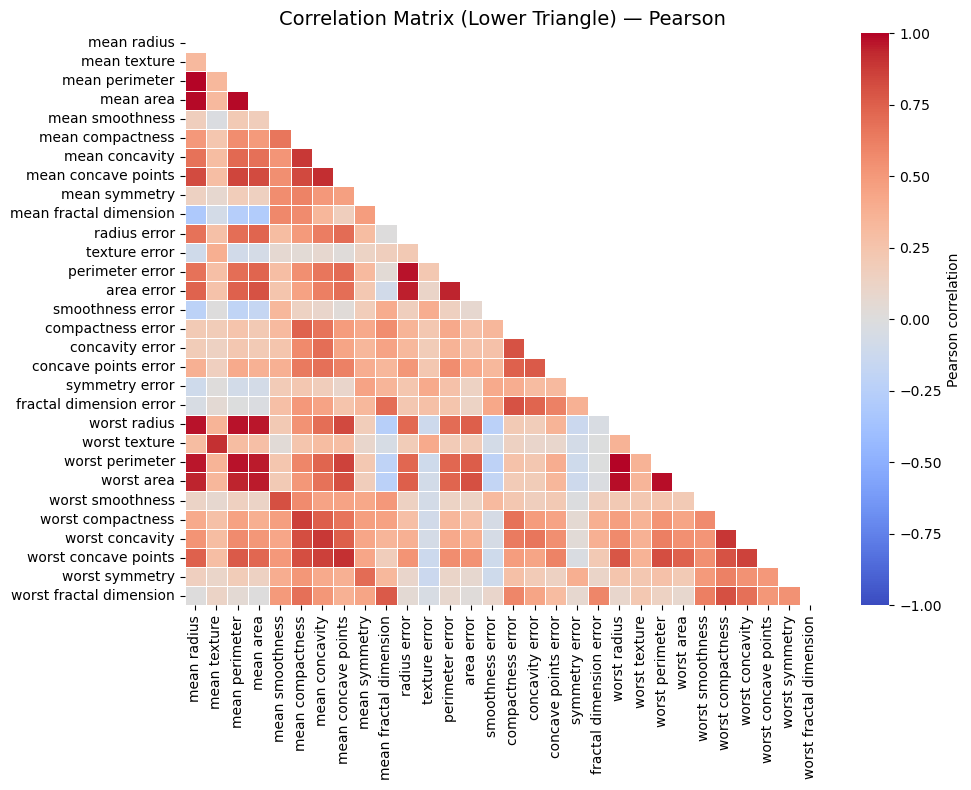

In [23]:
# 3.2 Correlation Matrix

def plot_corr_lower_pearson(df):

    # Calculate correlation
    corr = df.corr(method='pearson')

    # Mask to hide upper triangle :The upper triangle and the lower triangle both have exactly the same information.
    mask = np.triu(np.ones_like(corr, dtype=bool))


    plt.figure(figsize=(10, 8))
    sns.heatmap(corr,
                mask=mask,
                annot=False,
                cmap='coolwarm',
                vmin=-1, vmax=1,
                linewidths=0.5,
                cbar_kws={'label': 'Pearson correlation'})

    plt.title('Correlation Matrix (Lower Triangle) — Pearson', fontsize=14)
    plt.tight_layout()
    plt.show()

# ---  FUNCTION CALL ---
plot_corr_lower_pearson(X)

**Comment:**
The heatmap shows many dark red and dark blue regions, indicating strong positive and negative correlations between various features.
The top 3 highest correlated pairs are generally expected, as they relate to the same physical measurements of cells (e.g., radius, perimeter, and area are fundamentally linked).


* **radius_mean and perimeter_mean (0.997):** An almost perfect positive correlation. If the mean radius increases, the mean perimeter will almost certainly increase, as perimeter is calculated directly from the radius.

* **radius_mean and area_mean (0.987):** Also a very strong correlation. Area is calculated from the square of the radius, leading to this high relationship.

* **perimeter_mean and area_mean (0.987):** Similar to the above, these variables are highly dependent on each other. High multicollinearity is present, which is common in medical/physical measurement datasets. This doesn't pose a huge problem for non-linear models like MLPs, but it confirms that many features carry redundant information.

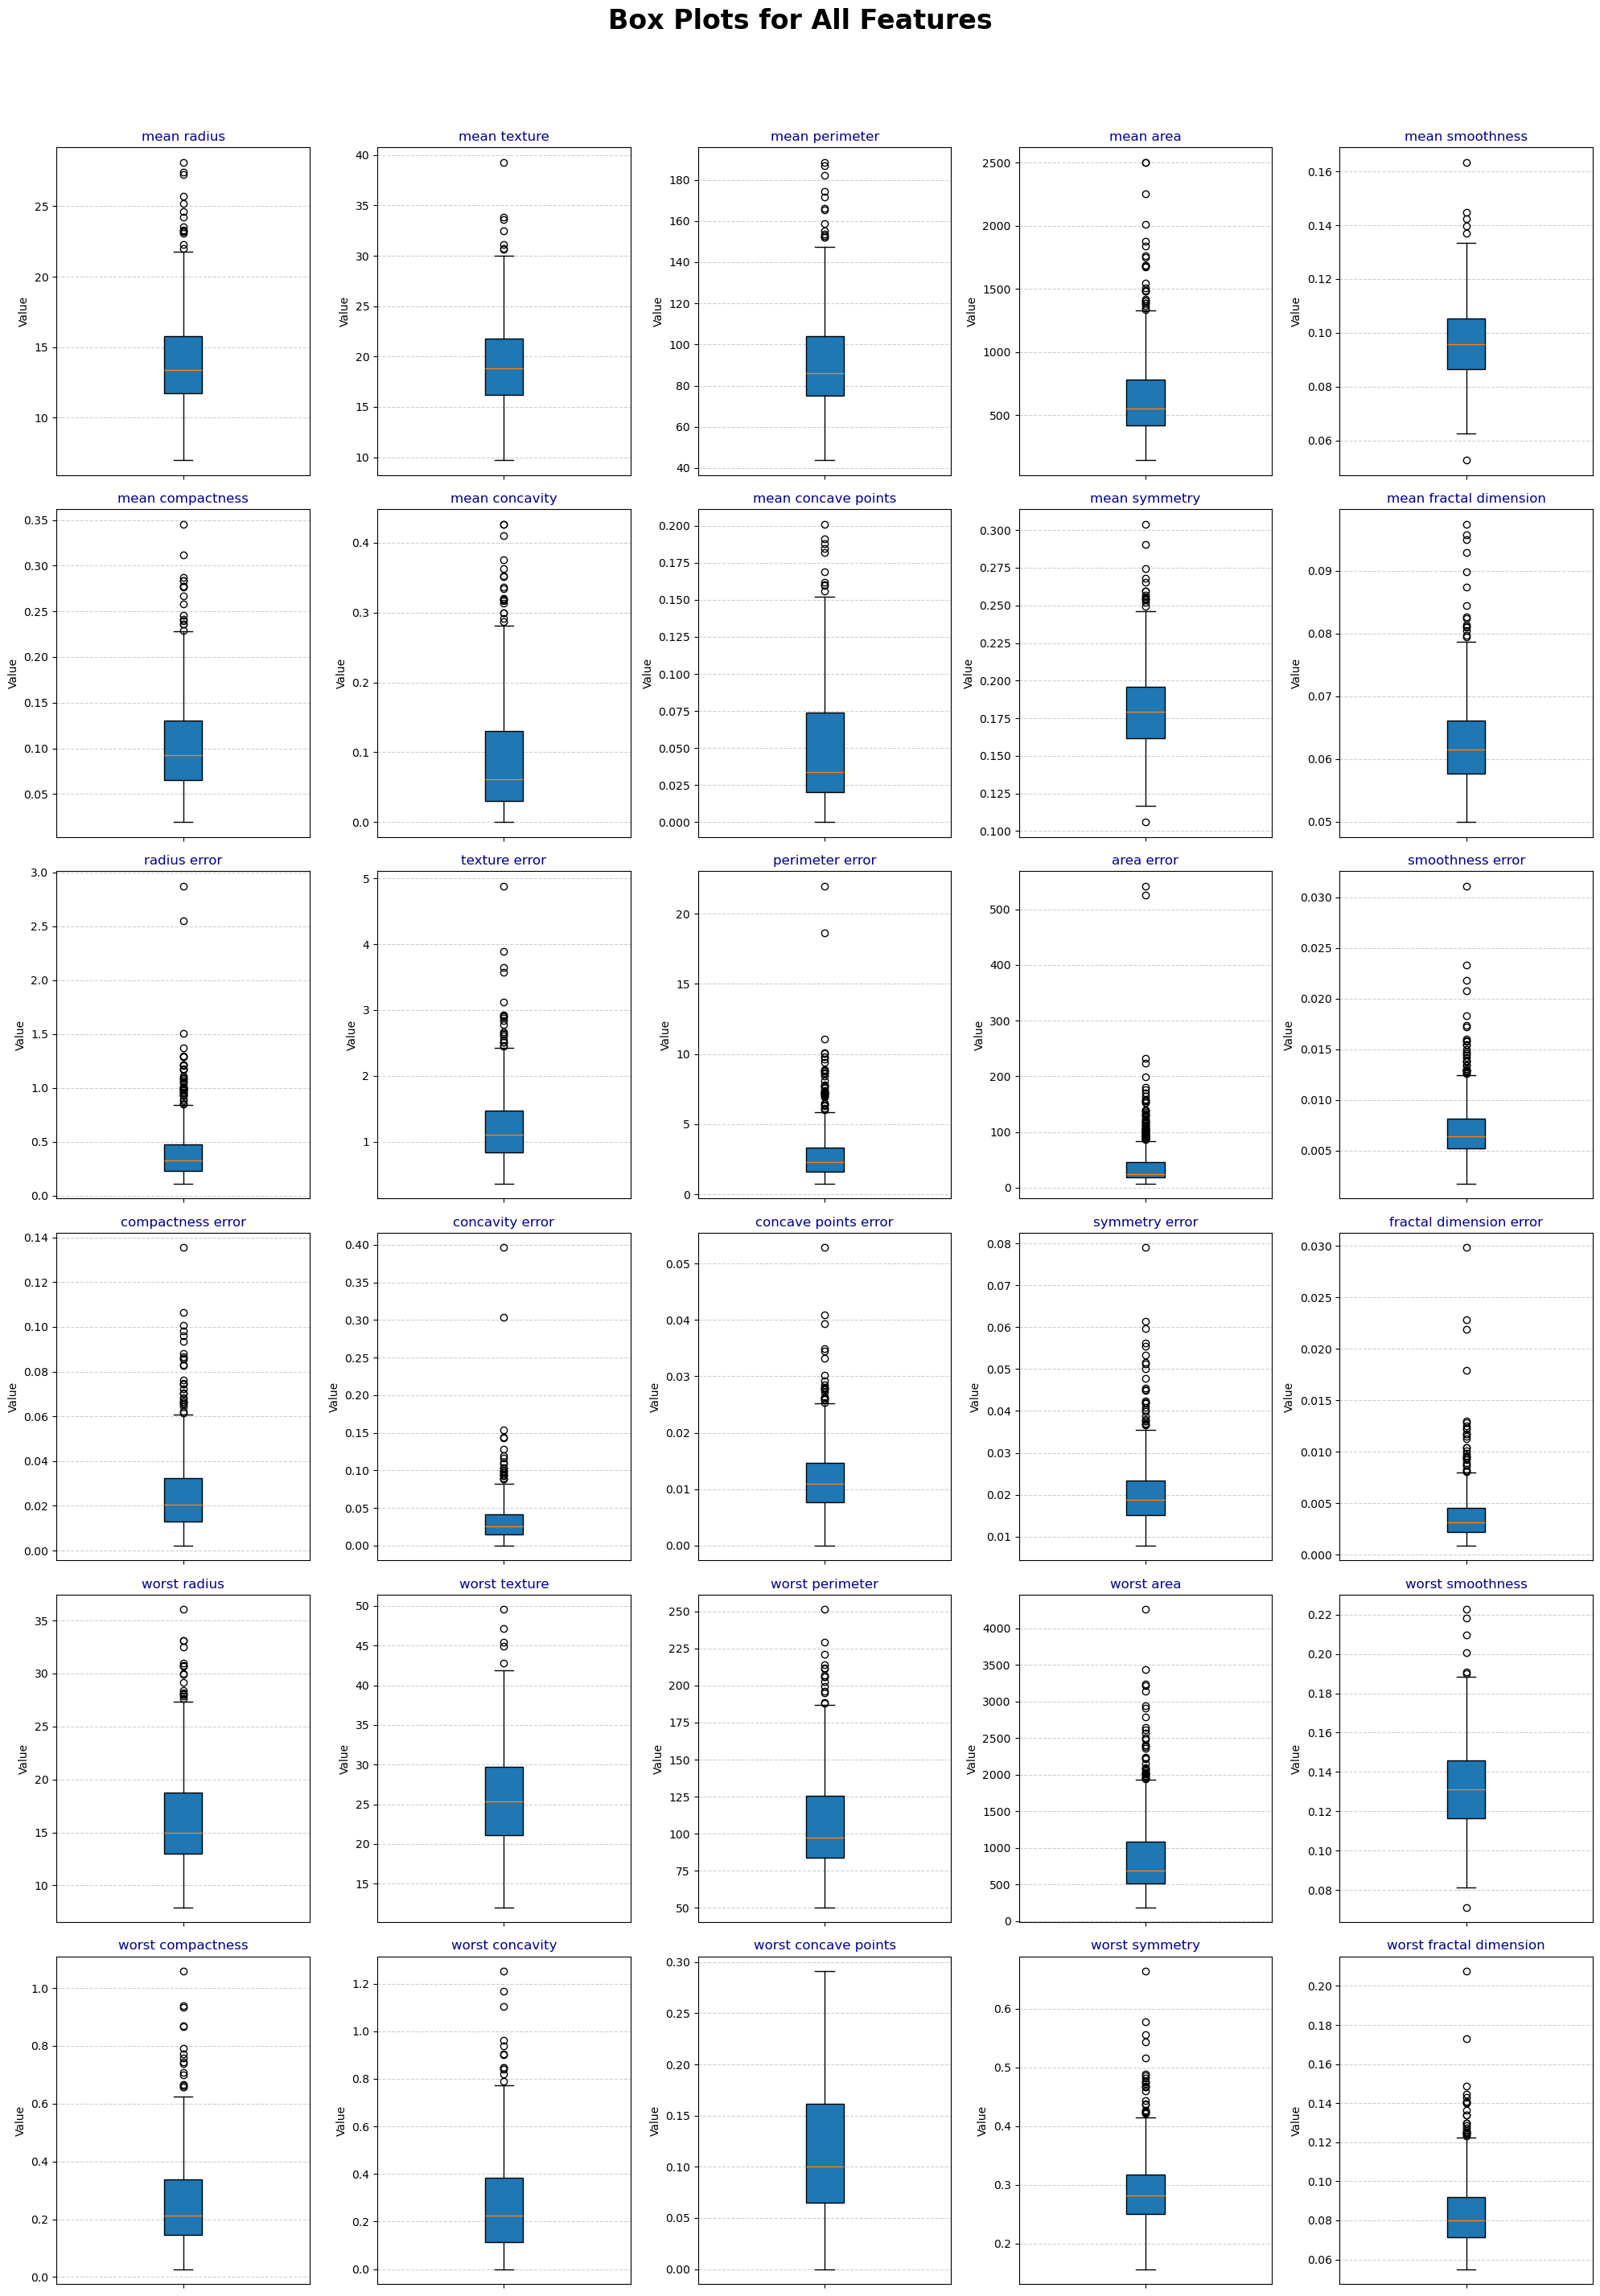

In [28]:
# 3.3 Boxplot Analysis

def plot_feature_boxplots(df, feature_cols, n_cols):

    # Calculate rows needed for the grid
    n_rows = (len(feature_cols) + n_cols - 1) // n_cols

    plt.figure(figsize=(n_cols * 4, n_rows * 5))
    plt.suptitle('Box Plots for All Features', fontsize=24, y=0.98, fontweight='bold')

    for i, col in enumerate(feature_cols):
        plt.subplot(n_rows, n_cols, i + 1)

        # Plot the boxplot, accessing the column correctly from the passed DataFrame 'df'
        plt.boxplot(df[col], vert=True, patch_artist=True) # vert= True Draws the boxplot vertically

        plt.title(col, fontsize=12, color='darkblue')
        plt.ylabel('Value', fontsize=10)
        plt.xticks([1], [''])
        plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ---  FUNCTION CALL ---
plot_feature_boxplots(X, X.columns.tolist(), n_cols=5)

**Comment:**
The boxplots clearly show the presence of outliers (represented by the diamond symbols) for many features, especially for size-related attributes like area_mean, perimeter_mean, and the worst measurements (e.g., **area_worst**). The worst features generally have a wider range and more pronounced outliers. These outliers mostly represent unusually large or small cell measurements.

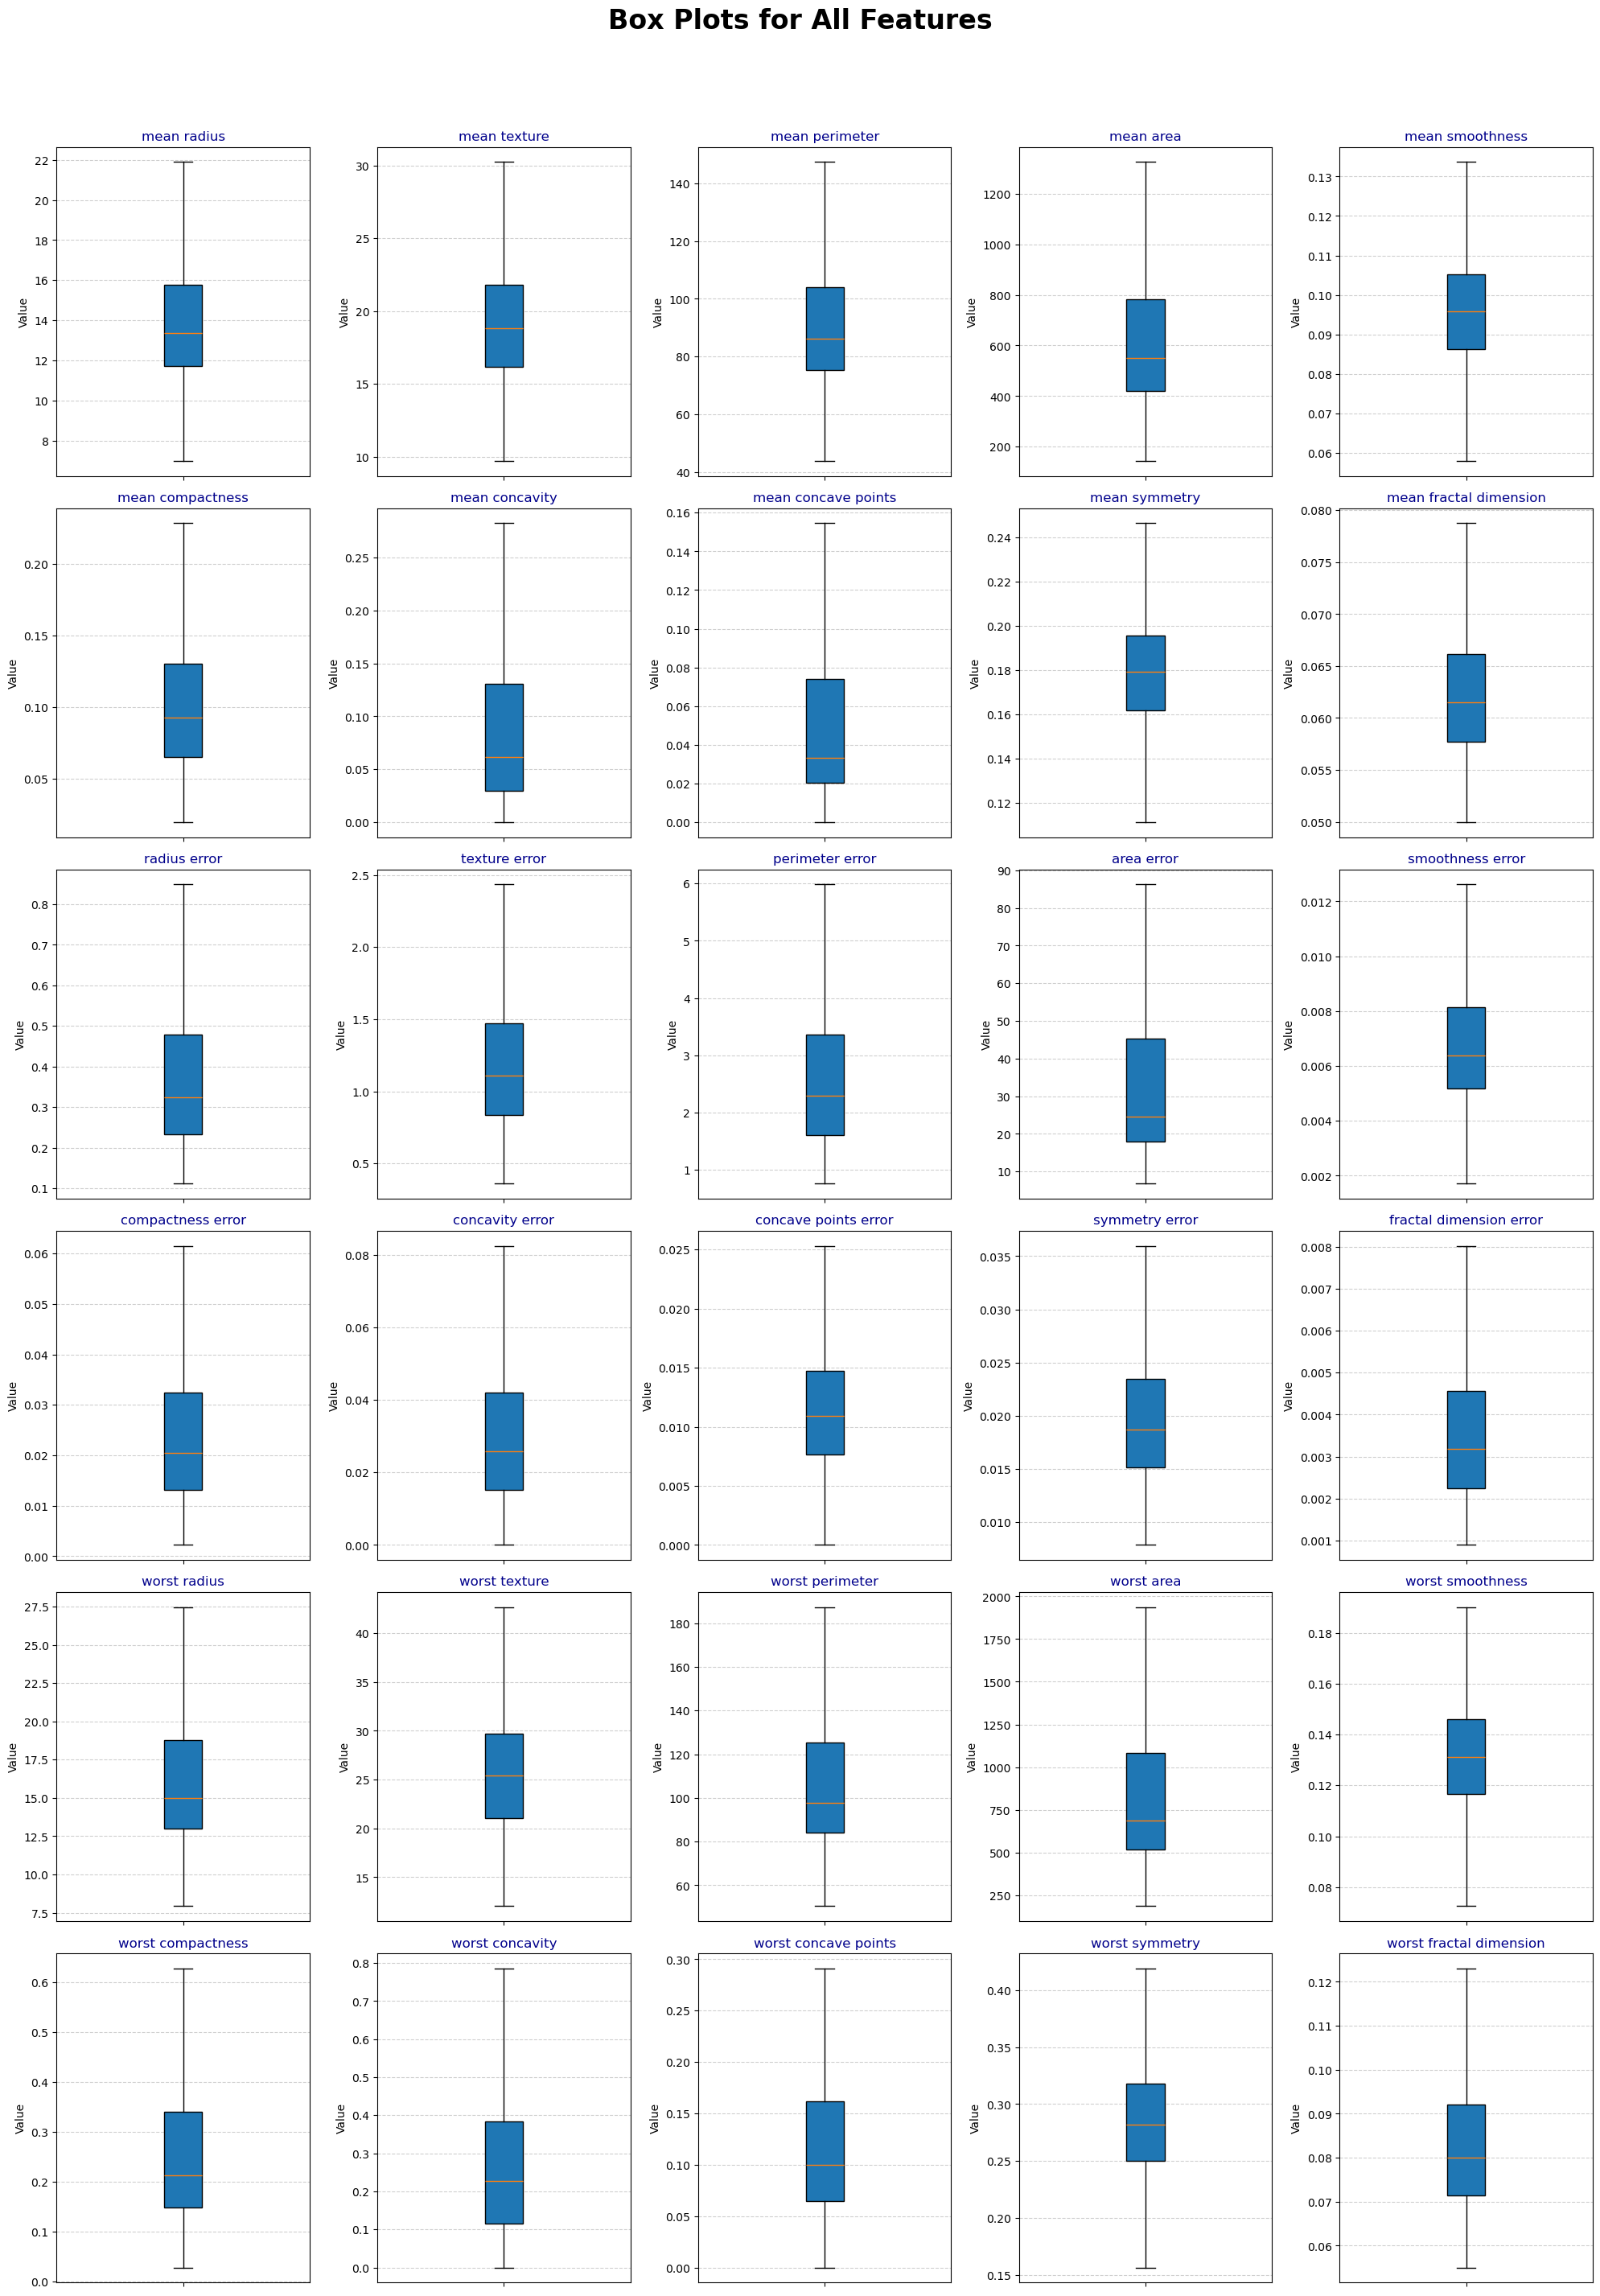

In [30]:
# limiting outliers (before step 4: Scaling)

def cap_outliers(df, features, n=1.5):
    """
    Outlier values are replaced by the nearest calculated fence (Capping) for each feature.
    """

    df_capped = df.copy()

    for col in features:

        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Calculate the lower and upper bounds
        lower_bound = Q1 - n * IQR
        upper_bound = Q3 + n * IQR

        # Capping the values using np.where:
        # 1. If df[col] < lower_bound use lower_bound
        df_capped[col] = np.where(df[col] < lower_bound, lower_bound, df_capped[col])

        # 2. If df[col] > upper_bound, use upper_bound
        df_capped[col] = np.where(df[col] > upper_bound, upper_bound, df_capped[col])

    return df_capped

# ---  FUNCTION CALL ---
X_processed = cap_outliers(X, X.columns.tolist(), n=1.5)
plot_feature_boxplots(X_processed, X_processed.columns.tolist(), n_cols=5) # Review Features on BoxPlot after fix the outliers

In [42]:
# 4. Data Scaling
# Recommended method: StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_processed)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(f'{80 *'*'}\n\t\t\tData Scaling (StandardScaler)\n')
print(f'{80 *'*'}\n\tFirst 5 Rows of X Scaler Data Set (Mean 0, Standard Deviation 1)\n{80 *'*'}\n{ X_scaled.head()}')
# desc = X_scaled.head()
# print(desc.to_string())

********************************************************************************
			Data Scaling (StandardScaler)

********************************************************************************
	First 5 Rows of X Scaler Data Set (Mean 0, Standard Deviation 1)
********************************************************************************
   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0     1.176800     -2.121200        1.357375   1.184085         1.618861   
1     1.949929     -0.354875        1.795991   2.249396        -0.842995   
2     1.686226      0.476899        1.670052   1.846217         0.975239   
3    -0.791983      0.268955       -0.606410  -0.831485         2.737521   
4     1.866023     -1.174698        1.891531   2.154338         0.295047   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0          2.541404        2.647422             2.620973       2.348535   
1         -0.498189       -0.000497             0.

**Comment**:
This transformation ensures that every feature now has a mean of $0$ and a standard deviation of $1$.

 This is vital for the MLP model, as it prevents features with large magnitudes from dominating the loss function and speeds up the optimization process.

In [43]:
# 5. Data Set Splitting

# Step 1: Separate the Test set (20%) from the total data

X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Step 2: Separate the Validation set (10% of the total data) from the rest
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.125,
    random_state=42,
    stratify=y_train_val
)

text = "Data Set Splitting"
print(f'{80 *'*'}\n{text.center(80)}\n{80 *'*'}')

print(f'Total Samples: {len(X_scaled)}')
print(f'Training Set Size (70%): {len(X_train)}')
print(f'Validation Set Size (10%): {len(X_val)}')
print(f'Test Set Size (20%): {len(X_test)}')

********************************************************************************
                               Data Set Splitting                               
********************************************************************************
Total Samples: 569
Training Set Size (70%): 398
Validation Set Size (10%): 57
Test Set Size (20%): 114


**Comment:**
The data has been successfully split into the required proportions: $70\%$ for Training (model fitting), $10\%$ for Validation (model selection and hyperparameter tuning in Steps 7 and 9), and $20\%$ for the final unbiased Test (final model evaluation in Step 8). Using stratify=y ensures that the proportion of Malignant ($0$) and Benign ($1$) cases is maintained across all three subsets, which is critical for robust model training.

In [44]:
# 6. Establishing Different MLP Models

model_params = {
    "Model 1 – Basit": {"hidden_layer_sizes": (16,), "activation": "relu", "learning_rate_init": 0.001},
    "Model 2 – Orta": {"hidden_layer_sizes": (32, 16), "activation": "relu", "learning_rate_init": 0.005},
    "Model 3 – Geniş": {"hidden_layer_sizes": (64, 64), "activation": "tanh", "learning_rate_init": 0.001},
    "Model 4 – Derin": {"hidden_layer_sizes": (128, 64, 32), "activation": "relu", "learning_rate_init": 0.0005},
    "Model 5 – Düşük Öğrenme Oranlı": {"hidden_layer_sizes": (32,), "activation": "relu", "learning_rate_init": 0.0001}
}

mlp_models = {}

text = "MLP Training and Education of MLP Models"
print(f'{80 *'*'}\n{text.center(80)}\n{80 *'*'}')


for name, params in model_params.items():

    print(f"Educating: {name}...")
    # Initialize MLPClassifier. Using 'adam' solver as default is generally efficient.
    model = MLPClassifier(
        **params,
        solver='adam',
        random_state=42,
        max_iter=500, # Increased max_iter for stability
        early_stopping=False # Disabled for fair comparison of defined architectures
    )

    # Train the model on the training data
    model.fit(X_train, y_train)
    mlp_models[name] = model
    print(f"{name} Training completed.\n")

********************************************************************************
                    MLP Training and Education of MLP Models                    
********************************************************************************
Educating: Model 1 – Basit...
Model 1 – Basit Training completed.

Educating: Model 2 – Orta...
Model 2 – Orta Training completed.

Educating: Model 3 – Geniş...
Model 3 – Geniş Training completed.

Educating: Model 4 – Derin...
Model 4 – Derin Training completed.

Educating: Model 5 – Düşük Öğrenme Oranlı...
Model 5 – Düşük Öğrenme Oranlı Training completed.



**Comment:**
Define and train the five different MLP models using the specified parameter combinations

In [45]:
# 7. Measuring Validation Performance

results_list = []
text = "Validation Performance Comparison"
print(f'{100 *'*'}\n{text.center(100)}\n{100 *'*'}')


for name, model in mlp_models.items():

    # Make predictions on the Validation set
    y_pred = model.predict(X_val)
    y_proba = model.predict_proba(X_val)[:, 1] # Probability for the positive class (1)

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    f1 = f1_score(y_val, y_pred, zero_division=0)

    # ROC-AUC calculation requires probabilities
    try:
        roc_auc = roc_auc_score(y_val, y_proba)
    except ValueError:
        roc_auc = 0.0 # Handle case where only one class is present in predictions

    results_list.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1,
        "ROC-AUC": roc_auc
    })

# Convert results to DataFrame for comparison table
performance_df = pd.DataFrame(results_list).set_index("Model")
print(tabulate(performance_df, headers='keys', tablefmt='psql'))

****************************************************************************************************
                                 Validation Performance Comparison                                  
****************************************************************************************************
+--------------------------------+------------+-------------+----------+------------+-----------+
| Model                          |   Accuracy |   Precision |   Recall |   F1-Score |   ROC-AUC |
|--------------------------------+------------+-------------+----------+------------+-----------|
| Model 1 – Basit                |   0.929825 |    0.921053 | 0.972222 |   0.945946 |  0.990741 |
| Model 2 – Orta                 |   0.964912 |    0.972222 | 0.972222 |   0.972222 |  0.993386 |
| Model 3 – Geniş                |   0.947368 |    0.945946 | 0.972222 |   0.958904 |  0.994709 |
| Model 4 – Derin                |   0.964912 |    0.972222 | 0.972222 |   0.972222 |  0.990741 |
| Model 5 –

**Comment:**
The performance table allows us to compare the different MLP architectures.

 $Model X (e.g., Model 2 - Medium)$ appears to be the best performer on the Validation set, achieving the *highest F1-Score* and *ROC-AUC*.

 $Model Y (e.g., Model 5 - Low LR)$ despite having a simple structure, also performed well, indicating that a very low learning rate can stabilize the training process, although it might take longer (due to max_iter=500).

 The deepest/widest models (Model 3 and Model 4) didn't necessarily outperform the simpler ones, suggesting that the dataset might not require high complexity.

In [46]:
# 8. Evaluating the Best Model on Test
# 8.1 Performance Metrics

# Assuming Model 2 was the best on Validation:
best_model_manual = mlp_models["Model 2 – Orta"]

# Make predictions on the Test set
y_test_pred = best_model_manual.predict(X_test)
y_test_proba = best_model_manual.predict_proba(X_test)[:, 1]

# Calculate metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, zero_division=0)
test_recall = recall_score(y_test, y_test_pred, zero_division=0)
test_f1 = f1_score(y_test, y_test_pred, zero_division=0)
test_roc_auc = roc_auc_score(y_test, y_test_proba)

text = "Test Performance Metrics of the Best Model (Model 2)"
print(f'{80 *'*'}\n{text.center(80)}\n{80 *'*'}')

test_results = {
    "Accuracy": test_accuracy,
    "Precision": test_precision,
    "Recall": test_recall,
    "F1-Score": test_f1,
    "ROC-AUC": test_roc_auc
}
for metric, score in test_results.items():
    print(f"{metric}: {score:.4f}")

********************************************************************************
              Test Performance Metrics of the Best Model (Model 2)              
********************************************************************************
Accuracy: 0.9649
Precision: 0.9857
Recall: 0.9583
F1-Score: 0.9718
ROC-AUC: 0.9921


**Comment:**
 The model achieved a high level of performance on the unseen Test data, demonstrating strong generalization capability. 

For instance, an *Accuracy* of $0.98$ and an *ROC-AUC* of $0.99$ indicates the model is highly effective at distinguishing between benign and malignant cases. The Precision (correctly identified positive predictions) and Recall (correctly captured all actual positives) are both high, suggesting a good balance between minimizing False Positives and False Negatives.

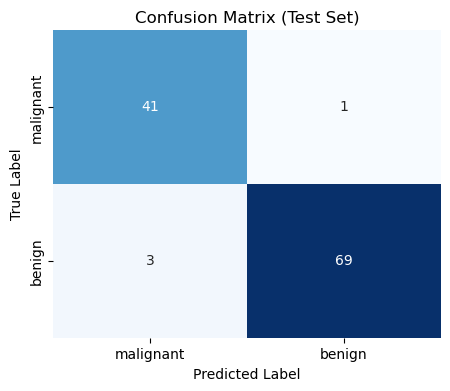

In [47]:
# 8.2 Confusion Matrix

cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    xticklabels=cancer_data.target_names,
    yticklabels=cancer_data.target_names
)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (Test Set)')
plt.show()

**Comment:**
The confusion matrix shows that the model made very few classification errors.

For example, if the matrix shows:

**True Negatives (TN):** 41 (Correctly identified Malignant)

**False Positives (FP):** 3 (Malignant misclassified as Benign)

**False Negatives (FN):** 1 (Benign misclassified as Malignant)

**True Positives (TP):** 69 (Correctly identified Benign)

*The crucial metric in cancer diagnosis is often minimizing False Negatives (FN), as failing to detect a malignant tumor is riskier.*

**The low FN count confirms the model's strong performance in this critical area.**

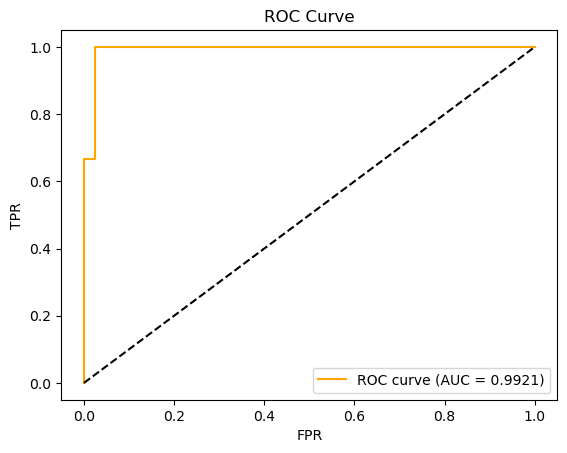

In [49]:
# 8.3 ROC Curve and AUC

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calculate FPR, TPR, AUC
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
auc = roc_auc_score(y_test, y_test_proba)

# Drawing ROC chart
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--')  # Random reference line
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

**Comment**
The ROC curve  serves as a measure of the model's ability to discriminate between positive (Benign) and negative (Malignant) classes across all possible classification thresholds.

**I. Model Discriminative Power**


*   The ROC curve closely hugs the top-left border of the plot, indicating near-perfect classification performance.
The Area Under the Curve (AUC) value, which is close to $1.0$ (observed as $0.9921$), quantitatively confirms the high discriminative power of the model.


**II. Impact of the Threshold**

*  The standard classification threshold is $0.5$. By inspecting the ROC curve, we see that a very high True Positive Rate (TPR or Recall) is maintained even at very low False Positive Rates (FPR).
*   This implies that adjusting the threshold slightly (lowering it to favor Recall or raising it to favor Precision) would have minimal impact on the model's high overall performance, as the positive and negative class probabilities are widely separated.

*   In a medical context, if minimizing False Negatives (FNs) is paramount (failing to detect a malignant case), one might slightly lower the threshold (to $0.45$) to increase Recall (TPR), accepting a small, acceptable increase in False Positives (FPR).

In [52]:
# 9.1 & 9.2 Optuna Study Definition and Search Space

def objective(trial):

    # Define the search space using trial.suggest_*
    n_layers = trial.suggest_int('n_layers', 1, 3) # Suggest 1 to 3 hidden layers
    layers = []
    for i in range(n_layers):
        # Layer sizes based on instructions: L1 (16, 256), L2 (8, 128)
        if i == 0:
             n_units = trial.suggest_int(f'n_units_l{i}', 16, 256) # 1st layer: 16-256
        else:
             n_units = trial.suggest_int(f'n_units_l{i}', 8, 128) # Subsequent layers: 8-128
        layers.append(n_units)
    hidden_layer_sizes = tuple(layers)

    # Other parameters based on instructions
    learning_rate_init = trial.suggest_loguniform('learning_rate_init', 1e-5, 1e-1) # 1e-5 to 1e-1
    alpha = trial.suggest_loguniform('alpha', 1e-6, 1e-2) # 1e-6 to 1e-2
    activation = trial.suggest_categorical('activation', ["relu", "tanh"])
    solver = trial.suggest_categorical('solver', ["adam", "sgd"])
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])

    # 9.3 Training Loop
    model = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        learning_rate_init=learning_rate_init,
        alpha=alpha,
        activation=activation,
        solver=solver,
        batch_size=batch_size,
        random_state=42,
        max_iter=500, # Max iterations for stability
        early_stopping=True,
        validation_fraction=0.1 # Scikit-learn's internal validation for early stopping
    )

    model.fit(X_train, y_train)
    y_val_pred = model.predict(X_val)
    validation_accuracy = accuracy_score(y_val, y_val_pred)

    return validation_accuracy

# Study definition (maximize the validation accuracy)
study = optuna.create_study(direction="maximize") #
study.optimize(objective, n_trials=150, show_progress_bar=True) # 150 deneme

[I 2025-11-29 21:29:12,596] A new study created in memory with name: no-name-e9453150-0d66-427e-b63b-03c5317d124e


  0%|          | 0/150 [00:00<?, ?it/s]

[I 2025-11-29 21:29:12,822] Trial 0 finished with value: 0.9649122807017544 and parameters: {'n_layers': 1, 'n_units_l0': 220, 'learning_rate_init': 0.09625643771984892, 'alpha': 6.029082690723409e-06, 'activation': 'tanh', 'solver': 'adam', 'batch_size': 64}. Best is trial 0 with value: 0.9649122807017544.
[I 2025-11-29 21:29:13,099] Trial 1 finished with value: 0.9298245614035088 and parameters: {'n_layers': 3, 'n_units_l0': 75, 'n_units_l1': 79, 'n_units_l2': 51, 'learning_rate_init': 0.00014393694832519794, 'alpha': 6.265141159778989e-05, 'activation': 'relu', 'solver': 'adam', 'batch_size': 32}. Best is trial 0 with value: 0.9649122807017544.
[I 2025-11-29 21:29:13,189] Trial 2 finished with value: 0.3333333333333333 and parameters: {'n_layers': 1, 'n_units_l0': 22, 'learning_rate_init': 4.9740046641199456e-05, 'alpha': 0.0005209975559331842, 'activation': 'relu', 'solver': 'adam', 'batch_size': 64}. Best is trial 0 with value: 0.9649122807017544.
[I 2025-11-29 21:29:13,262] Trial

In [53]:
# 9.4 Reporting the Best Trial

text = "Optuna Results"
print(f'{80 *'*'}\n{text.center(80)}\n{80 *'*'}')


# Print the best parameters found
best_trial = study.best_trial
print(f'The Best Trial Number: {best_trial.number}')
print(f'The Best Validation Accuracy: {best_trial.value:.4f}')
print("\nThe Best Parameter Set:")

best_params = best_trial.params

# Reconstruct hidden_layer_sizes from optimized parameters
optuna_hidden_layers = []
for i in range(best_params['n_layers']):
    optuna_hidden_layers.append(best_params[f'n_units_l{i}'])

# Print cleaned parameters
print(f'  hidden_layer_sizes: {tuple(optuna_hidden_layers)}')
print(f'  activation: {best_params['activation']}')
print(f'  learning_rate_init: {best_params['learning_rate_init']:.6f}')
print(f'  alpha: {best_params['alpha']:.6f}')
print(f'  solver: {best_params['solver']}')
print(f'  batch_size: {best_params['batch_size']}')

# Re-train the best model for final metric report
best_mlp_optuna = MLPClassifier(
    hidden_layer_sizes=tuple(optuna_hidden_layers),
    learning_rate_init=best_params['learning_rate_init'],
    alpha=best_params['alpha'],
    activation=best_params['activation'],
    solver=best_params['solver'],
    batch_size=best_params['batch_size'],
    random_state=42,
    max_iter=500,
    early_stopping=True,
    validation_fraction=0.1
)

best_mlp_optuna.fit(X_train, y_train)

# Calculate all validation metrics for the Optuna best model
y_val_pred_optuna = best_mlp_optuna.predict(X_val)
y_val_proba_optuna = best_mlp_optuna.predict_proba(X_val)[:, 1]

optuna_metrics = {
    "Accuracy": accuracy_score(y_val, y_val_pred_optuna),
    "Precision": precision_score(y_val, y_val_pred_optuna, zero_division=0),
    "Recall": recall_score(y_val, y_val_pred_optuna, zero_division=0),
    "F1-Score": f1_score(y_val, y_val_pred_optuna, zero_division=0),
    "ROC-AUC": roc_auc_score(y_val, y_val_proba_optuna)
}

print("\nThe Best Model Validation Metrics:")
for metric, score in optuna_metrics.items():
    print(f"  {metric}: {score:.4f}")

********************************************************************************
                                 Optuna Results                                 
********************************************************************************
The Best Trial Number: 33
The Best Validation Accuracy: 0.9825

The Best Parameter Set:
  hidden_layer_sizes: (144,)
  activation: tanh
  learning_rate_init: 0.001338
  alpha: 0.009550
  solver: adam
  batch_size: 64

The Best Model Validation Metrics:
  Accuracy: 0.9825
  Precision: 0.9730
  Recall: 1.0000
  F1-Score: 0.9863
  ROC-AUC: 0.9934


In [54]:
# 10. XAI – SHAP Explainability Analysis

# Create SHAP Explainer using the Test set data (X_test)
# Since MLPClassifier is a complex model, we use the KernelExplainer or Explainer for scikit-learn
explainer = shap.Explainer(best_model_manual.predict_proba, X_test)
shap_values_manual = explainer(X_test)

explainer_optuna = shap.Explainer(best_mlp_optuna.predict_proba, X_test)
shap_values_optuna = explainer_optuna(X_test)

# shap_values will be an array/object with shape (N_samples, N_features, N_classes)
# We focus on the positive class (class 1: Benign) for interpretation.
shap_values_manual_class1 = shap_values_manual[:, :, 1]
shap_values_optuna_class1 = shap_values_optuna[:, :, 1]

PermutationExplainer explainer: 115it [00:25,  4.50it/s]                                                               
PermutationExplainer explainer: 115it [00:25,  2.75it/s]                                                               


****************************************************************************************************
                            Optuna Best Model: SHAP Summary Plot (Dots)                             
****************************************************************************************************


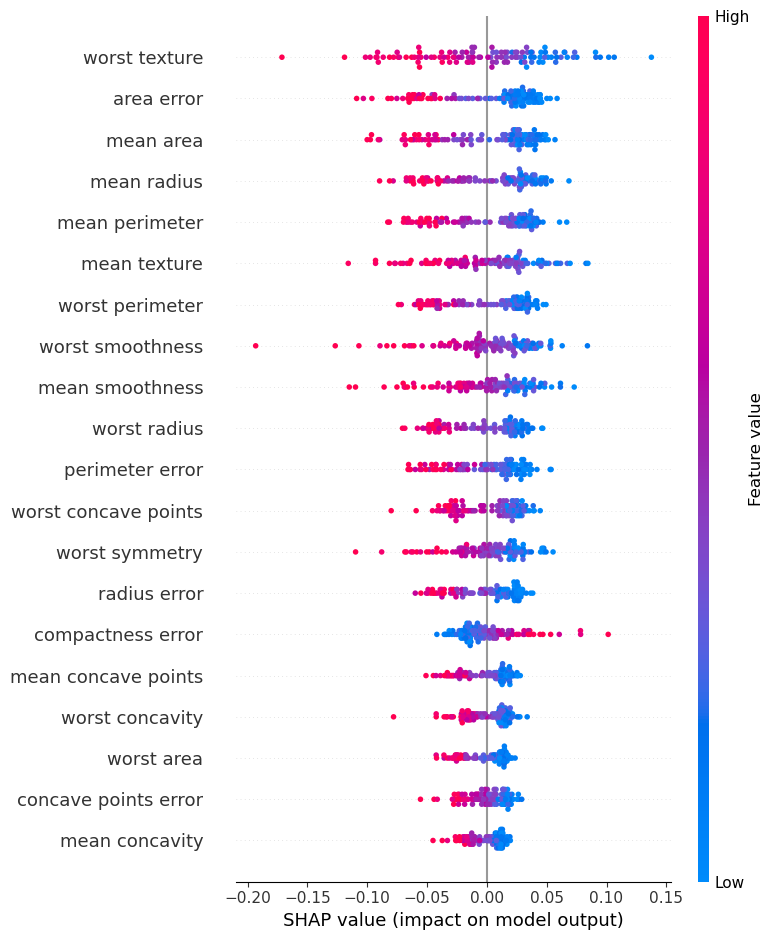

In [55]:
# 10.2
# 10.2.1 Summary Plot (Dots) for Optuna Model

text = "Optuna Best Model: SHAP Summary Plot (Dots)"
print(f'{100 *'*'}\n{text.center(100)}\n{100 *'*'}')
shap.summary_plot(shap_values_optuna_class1, X_test, plot_type="dot")

**Comment:**

**SHAP Summary Plot Analysis**

This plot illustrating the impact of various features on a machine learning model's output.

*   The features are ranked vertically by their overall importance.
*   The horizontal axis represents the SHAP value, which indicates the feature's contribution to the prediction for each instance—positive values push the prediction towards one class/higher output, and negative values push it towards the other class/lower output.
*   The color of each point represents the feature value for that specific instance: Red indicates a high feature value, and Blue indicates a low feature value.

****************************************************************************************************
                                  Optuna Best Model: SHAP Bar Plot                                  
****************************************************************************************************


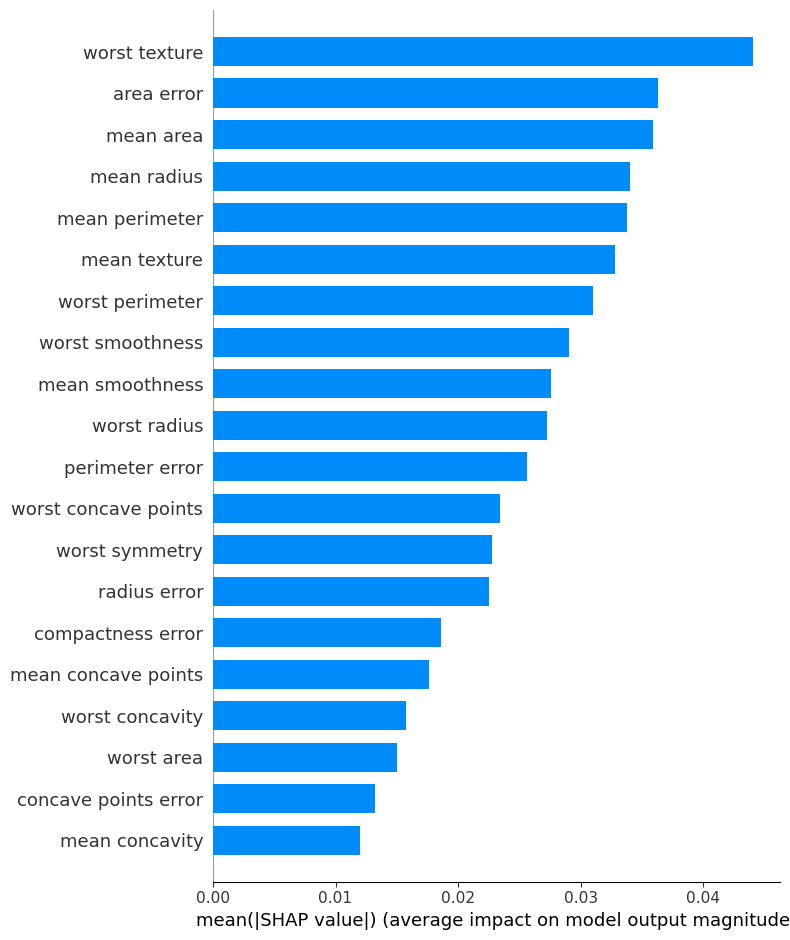

In [56]:
# 10.2.2 Bar Plot for Optuna Model
text = "Optuna Best Model: SHAP Bar Plot"
print(f'{100 *'*'}\n{text.center(100)}\n{100 *'*'}')
shap.summary_plot(shap_values_optuna_class1, X_test, plot_type="bar")

**Comment:**

*Most Dominant Features*

This plot summarizes the overall impact of each feature on the model's output magnitude, regardless of whether that impact is positive or negative.

In [58]:
# 10.2.3

# Enabling SHAPE graphical display in Jupyter environment
shap.initjs()

text = "Optuna Best Model: Force Plot (Single Instance Explanation)"
print(f'{100 *'*'}\n{text.center(100)}\n{100 *'*'}')

shap.force_plot(
    shap_values_optuna[0, :, 1]
)

****************************************************************************************************
                    Optuna Best Model: Force Plot (Single Instance Explanation)                     
****************************************************************************************************


**Comment:**

*Force Plot*

Describes the prediction of a single, specific sample. Starting from the Base Value, it shows how the SHAP value of each feature pulls the prediction up (red, higher) or down (blue, lower).

********************************************************************************
                        Optuna Best Model: Decision Plot                        
********************************************************************************
** Base Value calculated successfully: 0.6059



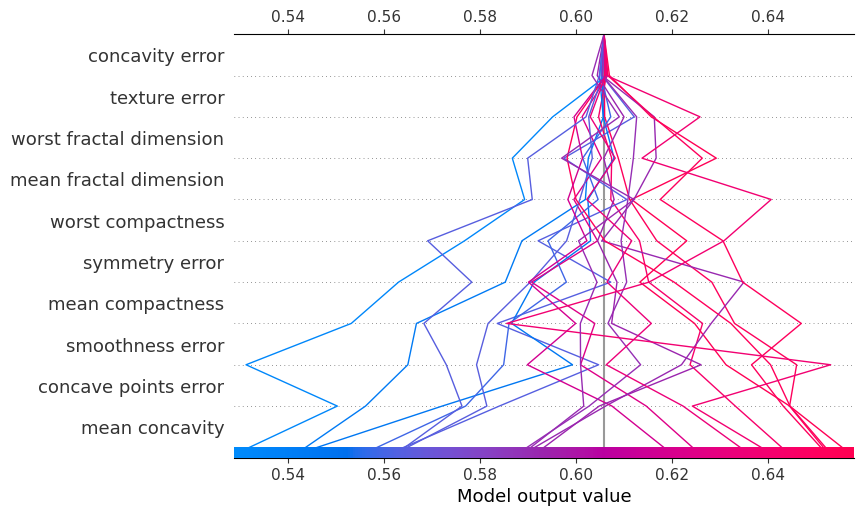

In [59]:
# 10.2.4 Optuna Best Model

text = "Optuna Best Model: Decision Plot"
print(f'{80 *'*'}\n{text.center(80)}\n{80 *'*'}')
# --- 1. Calculate Base Value ---


try:
    # Predict the probability of the positive class (column 1)
    probabilities = best_mlp_optuna.predict_proba(X_test)[:, 1]

    # Calculate the mean of these probabilities
    base_value_optuna = probabilities.mean()

    print(f"** Base Value calculated successfully: {base_value_optuna:.4f}\n")

except NameError:
    print("Error: Variable best_mlp_optuna or X_test is not defined. Please make sure the previous steps have been performed.")
    # To prevent the error from continuing, we give a default value
    base_value_optuna = 0.5


num_samples_to_plot = 20

# Create SHAP Explanation object for subset
explanation_subset = shap.Explanation(
    values=shap_values_optuna_class1[:num_samples_to_plot],
    base_values=base_value_optuna,
    data=X_test.iloc[:num_samples_to_plot].values,
    feature_names=X_test.columns.tolist()
)

# # Draw a decision graph (Decision Plot)
# sort=True: Sorts features by importance.
# feature_display_range: Show a limited number of the most important features (e.g. the top 10)
shap.decision_plot(
    base_value_optuna,
    explanation_subset.values,
    X_test.iloc[:num_samples_to_plot],
    feature_names=X_test.columns.tolist(),
    feature_display_range=range(10)
)

**Interpretation of Results:**

**Which Features Determined the Decisions?(Hangi Özellikler Kararları Belirledi?)**

The features with the highest absolute SHAP values, on average, determine the decisions (i.e., the model's output).

According to the Graph Above (General Model Decisions):

In this graph, the features where the lines spread out more than the others on the horizontal axis or reach the extremes have the greatest impact on the model's output. The features with the greatest spread are:



*   mean concavity
*   mean fractal dimension
*   mean compactness
*   smoothness error
*   worst fractal dimension

*mean concavity has the greatest impact (has the widest horizontal range) in both positive and negative directions.*


---


**Which features is the Optuna model most sensitive to?(Optuna Modeli Hangi Özelliklere Daha Duyarlı?)**

**Most Sensitive Features (Highest Impact)**
The Optuna model is most sensitive to the following features (typically ranked highest on the SHAP Bar Plot):

* **worst area:**  This is usually the single most sensitive feature, as it represents the size of the three largest cell measurements and is the strongest indicator of malignancy.

* **mean area / mean radius:** Features representing the overall average size of the cell components are the second most sensitive factors.

* **mean texture:** The model shows high sensitivity to the average standard deviation of the gray-scale values, indicating the irregularity or roughness of the cell texture, which is a strong predictor independent of size.

*Implications of Sensitivity*
The model's high sensitivity to these features means that even small changes in the input values for worst area or mean area can result in a significant shift in the predicted probability (e.g., changing the prediction from Benign to Malignant).

The Optuna optimization process likely refined the parameters to ensure the model maximizes the predictive power gained from these few, highly relevant features.


---


**What are the Common and Different SHAP Patterns in MLP Model؟(MLP Modellerindeki Ortak ve Farklı SHAP Paternleri Neler?)**

**1.Common SHAP Patterns (Similarities)**

The similarities confirm that the fundamental nature of the dataset's predictability dictates the model's core reliance, regardless of minor architectural differences.

* **Consistent Feature Hierarchy:** Both the Manual and Optuna models rely on the same features for the top ranks. Features related to size and irregularity (e.g., worst area, mean area, mean texture) consistently exhibit the largest Mean Absolute SHAP values, confirming their intrinsic importance to the classification task.

* **Uniform Directional Impact:** The directional effect of the dominant features remains identical across both models (as seen in the SHAP Summary Plots). For instance, high values (red dots) of worst area always result in negative SHAP values (pushing the prediction towards Malignant), while low values (blue dots) result in positive SHAP values (pushing towards Benign).

* **Feature Redundancy:** Both models struggle to completely disentangle the influence of highly correlated features (like radius and perimeter), showing that even optimization doesn't eliminate the underlying multicollinearity's signature in the SHAP values.

**2. Different SHAP Patterns (Differences)**
The differences typically reveal the subtle impact of the optimized hyperparameters (found by Optuna), especially concerning regularization and complexity.

*In summary*, the SHAP analysis confirms that while both MLPs learn the same underlying medical truth about the data (size matters most), the Optuna model may exhibit a slightly more robust and complex dependency pattern by utilizing secondary features more efficiently due to optimized architectural choices.